In [11]:
import sys
sys.path.append('/workspace/Storage_fast/AneurysmSegmentation/aneurysm_segmentation3d/')
sys.path.append('/workspace/Storage_fast/AneurysmSegmentation/')

import os
import panel as pn
import numpy as np
import pandas as pd
import pyvista as pv
import glob
import shutil
from omegaconf import OmegaConf
pn.extension('vtk')
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'
os.environ['PYVISTA_OFF_SCREEN'] = 'True'
os.environ['PYVISTA_USE_PANEL'] = 'True'

# Import BaseModel / BaseDataset for type checking
from torch_points3d.models.base_model import BaseModel
from torch_points3d.datasets.base_dataset import BaseDataset
from aneurysm_segmentation3d.scripts.dataset import AneurysmDataset



In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
# def load_random_data(event):
#     camera = [(0.0, 1.5, 1.5),
#              (0.0, 0.0, 0.0),
#              (0.0, 1.0, 0.0)]
#     path_data = np.random.choice(files)
#     data = np.load(path_data)
#     xyz = data[:, :3]
#     y = data[:, 3]
#     pl = pv.Plotter(notebook=True)
#     point_cloud = pv.PolyData(xyz)
#     point_cloud['fields'] = y
#     pl.add_points(point_cloud) 
#     pl.camera_position =  camera
    
#     pan.object = pl.ren_win
#     return point_cloud 

In [ ]:
# def load_random_data(event):
#     camera = [(0.0, 1.5, 1.5),
#              (0.0, 0.0, 0.0),
#              (0.0, 1.0, 0.0)]
#     path_data = np.random.choice(files)
#     data = np.load(path_data)
#     xyz = data[:, :3]
#     y = data[:, 3]
#     pl = pv.Plotter(notebook=True)
#     point_cloud = pv.PolyData(xyz)
#     point_cloud['fields'] = y
#     pl.add_points(point_cloud) 
#     pl.camera_position =  camera
    
#     pan.object = pl.ren_win
#     return point_cloud 

In [4]:
# Put path to output folder here
path = '/workspace/Storage_fast/AneurysmSegmentation/aneurysm_segmentation3d/scripts/visualization/out/'
files = glob.glob(os.path.join(path, '*.npy'))
files

['/workspace/Storage_fast/AneurysmSegmentation/aneurysm_segmentation3d/scripts/visualization/out/107_SA_pca_pred.npy',
 '/workspace/Storage_fast/AneurysmSegmentation/aneurysm_segmentation3d/scripts/visualization/out/18_EM_pca_pred.npy']

# Prediction Visualization

Colors - https://docs.pyvista.org/core/points.html 

In [6]:
import pyvista as pv
idx = 0
pred_npy_file = np.load(files[idx])
pred_df = pd.DataFrame(pred_npy_file, columns=['x','y','z','pred'])
pred_df["pred"] = pred_df["pred"].astype(int)

pred_df.pred.value_counts()

1    15268
Name: pred, dtype: int64

In [ ]:

# Visualize

plotter = pv.PlotterITK()
cols = ['x','y','z']

pc = pv.PolyData(np.array(pred_df[cols]))
plotter.add_mesh(pc, color='r', scalars= np.array(pred_df["pred"]))

plotter.show(True)


# Actual Label Visualization

In [12]:
BASE_DIR = "/workspace/Storage_fast/AneurysmSegmentation/aneurysm_segmentation3d"
CONF_DIR = os.path.join(BASE_DIR, "conf/kpconv_v2_base.yaml")
DATAROOT = os.path.join(BASE_DIR, "datasets/data")
PROCESSED_DIR = os.listdir(
    os.path.join(DATAROOT, "aneurysm/processed")
)

# Load Config file
params = OmegaConf.load(CONF_DIR)
params.dataroot = DATAROOT
# params.parts_to_segment = PARTS_TO_SEGMENT

In [13]:
dataset = AneurysmDataset.AneurysmDataset(params)
dataset

Dataset: AneurysmDataset 
train_pre_batch_collate_transform = None
val_pre_batch_collate_transform = None
test_pre_batch_collate_transform = None
pre_transform = Compose([
    NormalizeScale(),
    GridSampling3D(grid_size=0.02, quantize_coords=False, mode=mean),
])
test_transform = None
train_transform = Compose([
    RandomNoise(sigma=0.02, clip=0.05),
    RandomScaleAnisotropic([0.9, 1.1]),
])
val_transform = None
inference_transform = Compose([
    NormalizeScale(),
    GridSampling3D(grid_size=0.02, quantize_coords=False, mode=mean),
])
Size of train_dataset = 73
Size of test_dataset = 12
Size of val_dataset = 25
Batch size = None

In [14]:
dataset.train_dataset, dataset.val_dataset, dataset.test_dataset[0]

(Aneurysm(73), Aneurysm(25), Aneurysm(12))

In [15]:
params.features_to_include

{'mean_curvature': 0, 'gauss_curvature': 1, 'fpfh': 1, 'shot': 0, 'rf': 0, 'ones': 1}

In [16]:
sample= dataset.test_dataset[0][0]
sample_df = pd.DataFrame(sample.pos.numpy(), columns=['x','y','z'])
sample_df["label"] =  sample.y.numpy()
sample_df["label"] = sample_df["label"].astype(int)
sample_df.label.value_counts()

0    8311
1    2650
2     169
3      20
Name: label, dtype: int64

In [17]:
# Visualize

plotter = pv.PlotterITK()
cols = ['x','y','z']

pc = pv.PolyData(np.array(sample_df[cols]))
plotter.add_mesh(pc, color='r', scalars= np.array(sample_df["label"]))

plotter.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# INDIVIDUAL LABEL VISUALIZATION
#colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
p = pv.PlotterITK()
cols = ['x','y','z']

query_df = sample_df.query("label == 0").copy()
pc = pv.PolyData(np.array(query_df[cols]))
p.add_mesh(pc, color='r', scalars= np.array(query_df["label"]))

query_df = sample_df.query("label == 1").copy()
pc = pv.PolyData(np.array(query_df[cols]))
p.add_mesh(pc, color='b',scalars= np.array(query_df["label"]))

query_df = sample_df.query("label == 2").copy()
pc = pv.PolyData(np.array(query_df[cols]))
p.add_mesh(pc, color='m',scalars= np.array(query_df["label"]))

query_df = sample_df.query("label == 3").copy()
pc = pv.PolyData(np.array(query_df[cols]))
p.add_mesh(pc, color='r',scalars= np.array(query_df["label"]))

# p.background_color = 'm' 

p.show(True)


# cmap
from https://github.com/nicolas-chaulet/torch-points3d/blob/master/notebooks/s3dis_explorer.ipynb

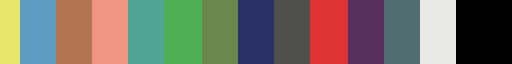

In [7]:
from matplotlib.colors import ListedColormap

OBJECT_COLOR = [
        [233, 229, 107],  #'ceiling' .-> .yellow
        [95, 156, 196],  #'floor' .-> . blue
        [179, 116, 81],  #'wall'  ->  brown
        [241, 149, 131],  #'beam'  ->  salmon
        [81, 163, 148],  #'column'  ->  bluegreen
        [77, 174, 84],  #'window'  ->  bright green
        [108, 135, 75],  #'door'   ->  dark green
        [41, 49, 101],  #'chair'  ->  darkblue
        [79, 79, 76],  #'table'  ->  dark grey
        [223, 52, 52],  #'bookcase'  ->  red
        [89, 47, 95],  #'sofa'  ->  purple
        [81, 109, 114],  #'board'   ->  grey
        [233, 233, 229],  #'clutter'  ->  light grey
        [0, 0, 0],  # unlabelled .->. black
    ]
def buil_cmap():
    mapping = np.linspace(0, len(OBJECT_COLOR), 256)
    newcolors = np.zeros((256, 3))
    for i, color in enumerate(OBJECT_COLOR):
        newcolors[mapping >= i-0.5] = np.asarray(color) / 255.
    return ListedColormap(newcolors)
cmap = buil_cmap()
cmap